Nick ran boxes at the same resolution as I did and his look great. Time to figure out why... 

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [28]:
import astropy.units as u
from astropy.cosmology import z_at_value

In [29]:
from lenstools.simulations.fastpm import FastPMSnapshot 
from lenstools.simulations.raytracing import DensityPlane, PotentialPlane, RayTracer
from lenstools.image.convergence import ConvergenceMap
import bigfile

In [30]:
%%bash
ls /home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/*

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/attr-v2
/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Aemit:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/ID:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Position:
000000
000001
000002
attr-v2
header

/home/users/swmclau2/scratch/UatuFastpmTest/Box001/lightcone/1/Velocity:
000000
000001
000002
attr-v2
header


In [31]:
class MyFastPMSnapshot(FastPMSnapshot):
    
    def getHeader(self):

        #Initialize header
        header = dict()
        bf_header = self.fp["."].attrs

        ###############################################
        #Translate fastPM header into lenstools header#
        ###############################################

        #Number of particles/files
        header["num_particles_file"] = bf_header["NC"][0]**3
        header["num_particles_total"] = header["num_particles_file"]
        header["num_files"] = 1

        #Cosmology
        header["Om0"] = bf_header["OmegaM"][0]
        header["Ode0"] = 1. - header["Om0"]
        header["w0"] = -1.
        header["wa"] = 0.
        header["h"] = bf_header['HubbleParam'][0]

        #Box size in kpc/h
        header["box_size"] = bf_header["BoxSize"][0]*1.0e3

        #Masses
        header["masses"] = bf_header['MassTable']*header["h"]

        #################

        return header
    def getPositions(self,first=None,last=None,save=True):

		#Get data pointer
		data = bigfile.BigData(self.fp)
		
		#Read in positions in Mpc/h
		if (first is None) or (last is None):
			positions = data["Position"][:]*self.Mpc_over_h
			#aemit = data["Aemit"][:]
		else:
			positions = data["Position"][first:last]*self.Mpc_over_h
			#aemit = data["Aemit"][first:last]

		#Enforce periodic boundary conditions
		for n in (0,1):
			positions[:,n][positions[:,n]<0] += self.header["box_size"]
			positions[:,n][positions[:,n]>self.header["box_size"]] -= self.header["box_size"]

		#Maybe save
		if save:
			self.positions = positions
			#self.aemit = aemit

		#Initialize useless attributes to None
		self.weights = None
		self.virial_radius = None
		self.concentration = None

		#Return
		return positions 

In [32]:
snap_path = "/home/users/swmclau2/scratch/UatuFastpmTest/Box000/"
#snap = MyFastPMSnapshot.open(snap_path)
#snap.getPositions()

In [33]:
nick_path = '/scratch/users/kokron/FastPMulus/Box000Replicate/Outputs_512/'
#snap = MyFastPMSnapshot.open(snap_path)
#snap.getPositions()

In [34]:
nick_ps = np.loadtxt("/home/users/kokron/Projects/FastPMulus/TestRun/pklin.txt")

In [35]:
my_ps = np.loadtxt('/scratch/users/swmclau2/UatuFastpmTest/Box001/class_pk.dat')

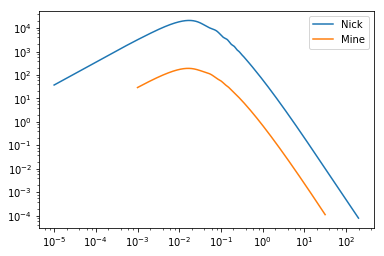

In [36]:
plt.plot(nick_ps[:,0], nick_ps[:,1], label = 'Nick')
plt.plot(my_ps[:,0], my_ps[:,1], label = 'Mine')
plt.legend(loc='best')
plt.loglog();

In [37]:
my_ps.shape

(600, 2)

In [38]:
nick_ps[:,0].min(), nick_ps[:,0].max()

(1e-05, 199.52623149688787)

In [39]:
from classy import Class

In [40]:
omega_m = 0.3405
h = 0.6333
sigma8 = 7.730715e-01
o_cdm = 1.140598e-01/(h**2)

In [48]:
(omega_m - o_cdm)*h**2

0.022504157044999997

In [93]:
def compute_pk(O_cdm, sigma8, outputdir):
    """
    Use class to compute the power spectrum and sigma 8 as initial conditions for the sims.
    :param o_cdm:
        Value of o_cdm to use in compuattion.
    :param ln_10_As:
        Vlaue of ln10^10A_s to use in computation
    :param outputdir:
        Outputdir to store the power specturm. It should be the same as where picola is loaded from.
    :return:
        sigma8. Return the value of sigma8 necessary to run the sims
    """

    #z = 20.0 #Note maybe allow to vary, or make global
    z = 0.0
    params = {
        'output': 'mPk',
        #'ln10^{10}A_s': ln_10_As,
        'sigma8': 7.730715e-01,
        'P_k_max_h/Mpc': 300.0,
        'n_s':  9.755890e-01,
        'h': 6.336569e+01/100,
        #'non linear': 'halofit',
        'omega_b': 2.268325e-02,
        'omega_cdm':  1.140598e-01,
        'z_pk': z}

    cosmo = Class()
    cosmo.set(params)

    cosmo.compute()#level = ["initnonlinear"])

    k_size = 1000
    ks = np.logspace(-5, 2.3, k_size).reshape(k_size,1,1)
    zs = np.array([z])

    pks =  cosmo.get_pk_lin(ks*h, zs, k_size, 1, 1)[:,0,0]*(h**3)

    #np.savetxt(path.join(outputdir, 'class_pk.dat'), np.c_[ks[:,0,0], pks],\
    #           delimiter = ' ')

    return np.c_[ks[:,0,0], pks] #cosmo.sigma8()


In [94]:
my_new_pk = compute_pk(o_cdm, sigma8, '')

In [95]:
my_new_pk[:10,0], nick_ps[:10,0]

(array([1.00000000e-05, 1.01696805e-05, 1.03422401e-05, 1.05177277e-05,
        1.06961930e-05, 1.08776865e-05, 1.10622595e-05, 1.12499645e-05,
        1.14408544e-05, 1.16349833e-05]),
 array([1.00000000e-05, 1.01696805e-05, 1.03422401e-05, 1.05177277e-05,
        1.06961930e-05, 1.08776865e-05, 1.10622595e-05, 1.12499645e-05,
        1.14408544e-05, 1.16349833e-05]))

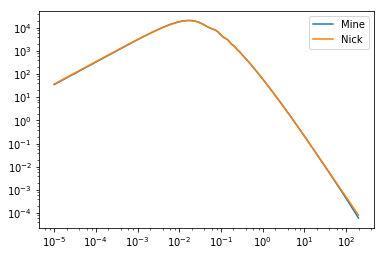

In [96]:
plt.plot(my_new_pk[:,0], my_new_pk[:,1], label = "Mine")
plt.plot(nick_ps[:,0], nick_ps[:,1], label = 'Nick')
plt.legend(loc='best')
plt.loglog();

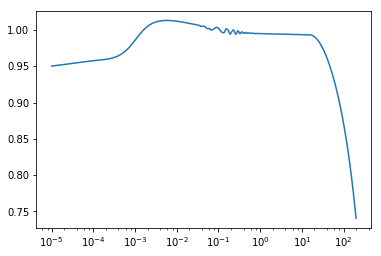

In [97]:
plt.plot(my_new_pk[:,0], my_new_pk[:,1]/nick_ps[:,1])
plt.xscale('log')